In [1]:
import mapsims
import numpy as np
import healpy as hp
import pysm3.units as u
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

# Running on the fly simulations with mapsims

The `mapsims` package allows to generate maps on-the-fly, so they can be generated as needed inside other pipelines.

The interface is the `SONoiseSimulator` class, specify `nside` to work with HEALPix maps, `shape` and `wcs` for CAR (see lesson 6).

The class constructor just initializes the configuration of the class, doesn't load neither spectra nor hitmaps.

In [2]:
mapsims.SONoiseSimulator?

Init signature:
mapsims.SONoiseSimulator(
    nside=None,
    shape=None,
    wcs=None,
    ell_max=None,
    return_uK_CMB=True,
    sensitivity_mode='baseline',
    apply_beam_correction=False,
    apply_kludge_correction=True,
    homogeneous=False,
    no_power_below_ell=None,
    rolloff_ell=50,
    survey_efficiency=0.2,
    full_covariance=True,
    LA_years=5,
    LA_noise_model='SOLatV3point1',
    elevation=50,
    SA_years=5,
    SA_one_over_f_mode='pessimistic',
    sky_fraction=None,
    cache_hitmaps=True,
    boolean_sky_fraction=False,
    instrument_parameters='simonsobs_instrument_parameters_2020.06',
)
Docstring:      <no docstring>
Init docstring:
Simulate noise maps for Simons Observatory

Simulate the noise power spectrum in spherical harmonics domain and then generate a map
in microK_CMB or microK_RJ (based on return_uK_CMB)

In the constructor, this object calls the published 20180822 noise simulator and generates
the expected noise power spectra for all channel

In [3]:
noise_sim = mapsims.SONoiseSimulator(nside=256)

The `simulate` method does all the processing, it loads the HEALPix or CAR hitmaps (from a path when run at NERSC or downloading and caching them locally) and calls the `so_noise_models` package to generate the expected spectra given the instrument configuration.

The hitmaps were generated in time domain executing parallel runs with TOAST and then saved to disk. They are only used as a relative weighting, the global noise properties are driven by the spectra from `so_noise_models`.

The `simulate` method gets the expected spectra, weights them by the sky fraction and then generates isotropic noise over the whole sky with `synfast` for HEALPix and `sym_expand` for CAR and then scales it by the relative hitmap.

It always simulates a dichroic tube at a time so that also the cross-correlation between the channels is simulated and captured in the output maps.

In [4]:
noise_sim.simulate?

Signature:
noise_sim.simulate(
    tube,
    output_units='uK_CMB',
    seed=None,
    nsplits=1,
    mask_value=None,
    atmosphere=True,
    hitmap=None,
    white_noise_rms=None,
)
Docstring:
Create a random realization of the noise power spectrum

Parameters
----------

tube : str
    Specify a tube (for SO: ST0-ST3, LT0-LT6) see the `tubes` attribute
output_units : str
    Output unit supported by PySM.units, e.g. uK_CMB or K_RJ
seed : integer or tuple of integers, optional
    Specify a seed. The seed is converted to a tuple if not already
    one and appended to (0,0,6,tube_id) to avoid collisions between
    tubes, with the signal sims and with ACT noise sims, where
    tube_id is the integer ID of the tube.
nsplits : integer, optional
    Number of splits to generate. The splits will have independent noise
    realizations, with noise power scaled by a factor of nsplits, i.e. atmospheric
    noise is assumed to average down with observing time the same way
    the white noise

In [5]:
tube = "LT1"

In [6]:
noise_maps = noise_sim.simulate(tube)

/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/healpix/LT1_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/healpix/LT1_UHF2_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


In [7]:
noise_maps.shape

(2, 1, 3, 786432)

In [8]:
channels = mapsims.parse_channels("tube:" + tube)[0]

In [9]:
channels

(Channel LT1_UHF1, Channel LT1_UHF2)

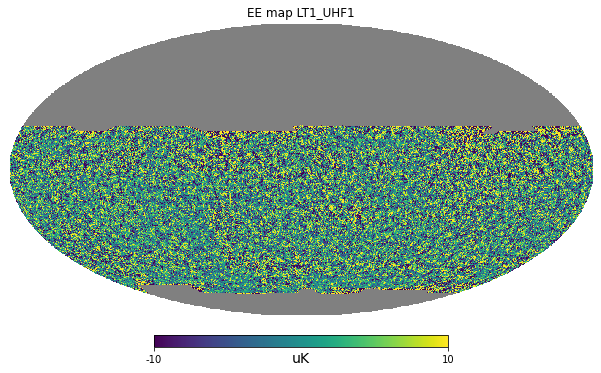

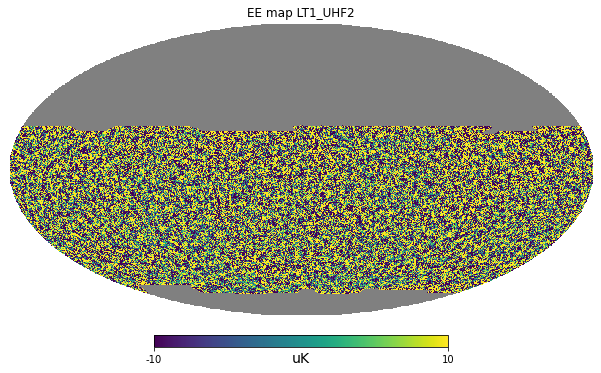

In [10]:
for ch, m in zip(channels, noise_maps):
    hp.mollview(m[0][1], title="EE map " + ch.tag, unit="uK", min=-10, max=10)

## Compare cross-spectra

We can take a cross-spectrum between the maps of the 2 tubes and compare with the expected spectrum from `noise.get_fullsky_noise_spectra`.



In [11]:
ell, ps_T, ps_P = noise_sim.get_fullsky_noise_spectra(tube=tube)

In [12]:
hitmaps, ave_nhits = noise_sim.get_hitmaps(tube=tube)

In [13]:
sky_fraction = (hitmaps[0] > 0).sum() / len(hitmaps[0])

In [14]:
noise_maps.shape

(2, 1, 3, 786432)

In [15]:
x_C_ell = hp.anafast(hp.ma(noise_maps[0][0])*hitmaps[0], hp.ma(noise_maps[1][0])*hitmaps[1]) / sky_fraction / np.mean(hitmaps[0]*hitmaps[1])

In [16]:
x_C_ell.shape

(6, 768)

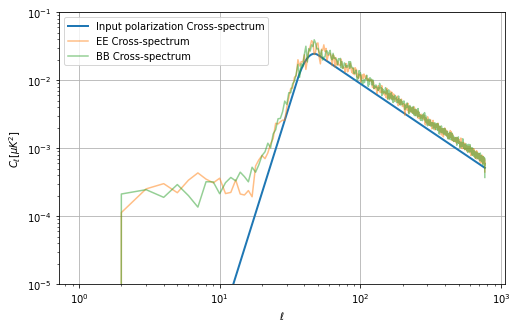

In [17]:
plt.figure(figsize=(8,5))
plt.loglog(ell, ps_P[2] * sky_fraction, lw=2, label="Input polarization Cross-spectrum")
plt.loglog(x_C_ell[1], label="EE Cross-spectrum", alpha=.5)
plt.loglog(x_C_ell[2], label="BB Cross-spectrum", alpha=.5)
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell [\mu K^2]$")
plt.grid()
plt.ylim(1e-5, 1e-1)
plt.legend();

## Simulate multiple tubes

A single `SONoiseSimulator` object is capable of simulating noise for different tubes. See for example a loop to simulate all SAT channels.

In [18]:
tubes = ["ST{}".format(i) for i in range(4)]

/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/healpix/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/healpix/ST0_UHF2_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/global/com

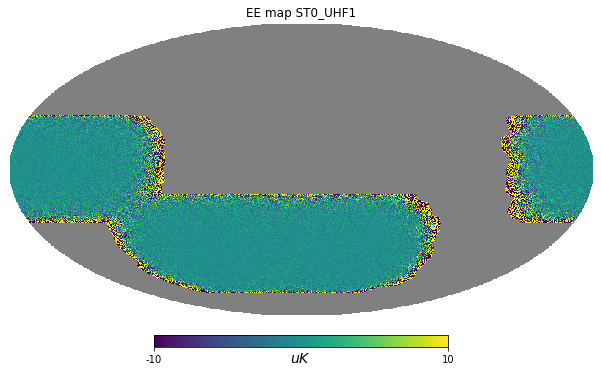

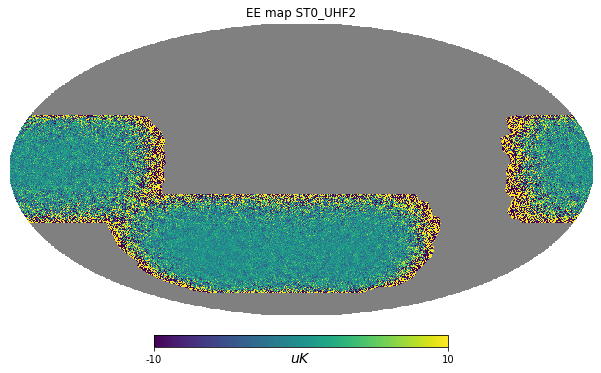

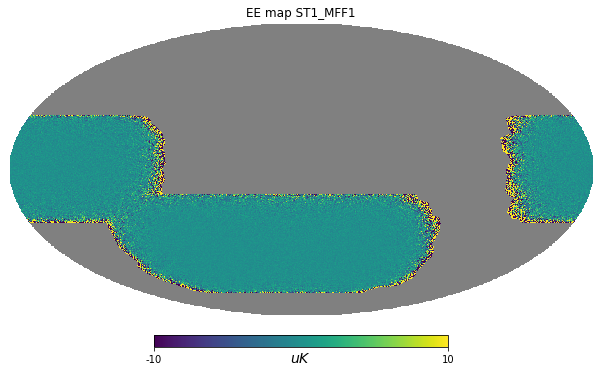

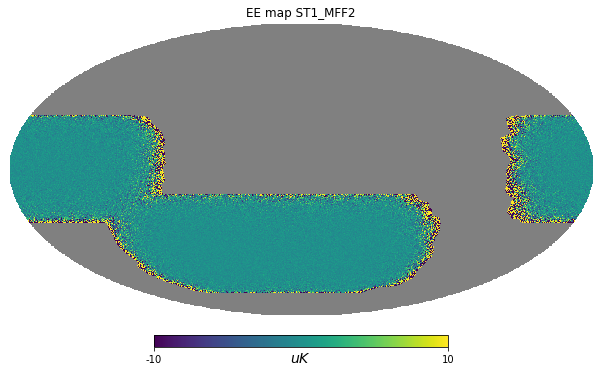

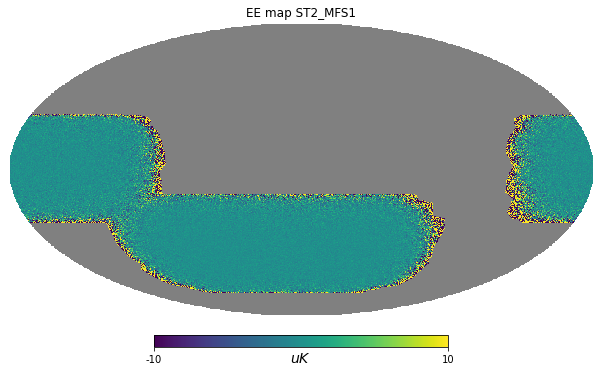

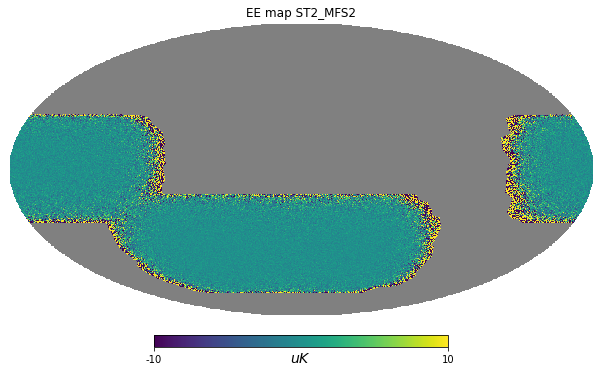

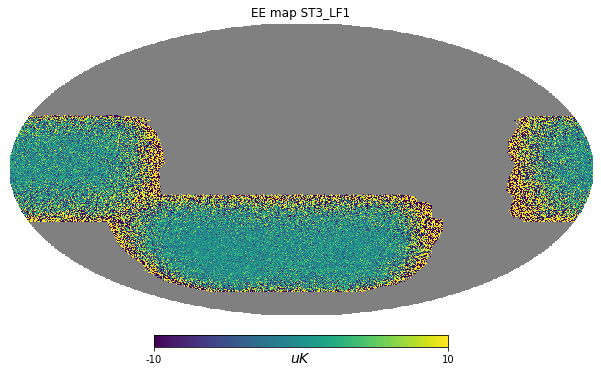

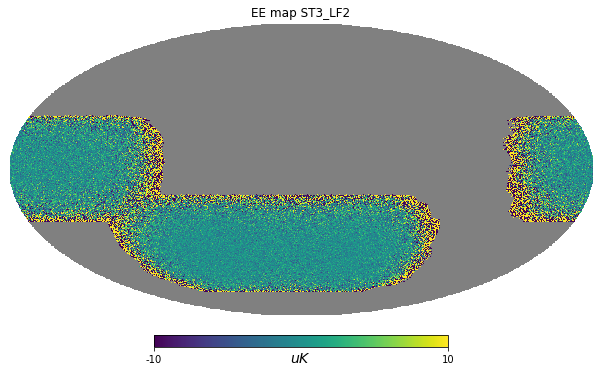

In [19]:
for tube in tubes:
    noise_maps = noise_sim.simulate(tube)
    for ch, m in zip(mapsims.parse_channels("tube:" + tube)[0], noise_maps):
        hp.mollview(m[0][1], title="EE map " + ch.tag, unit="$uK$", min=-10, max=10)

## Generate multiple splits

Override `nsplits` to generate multiple splits, the output maps will be a 3 dimensional array where for each split we have the 3 IQU components.

In [20]:
noise_maps_splits = noise_sim.simulate("ST0", nsplits=4)

In [21]:
noise_maps_splits.shape

(2, 4, 3, 786432)